In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.data import AUTOTUNE
import sentiment


DATASET_DIR = './goemotions/data-v2/'

In [2]:
classes = sentiment.load_classes(DATASET_DIR)
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

D:\sentiment-analysis\sentiment.py:392: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


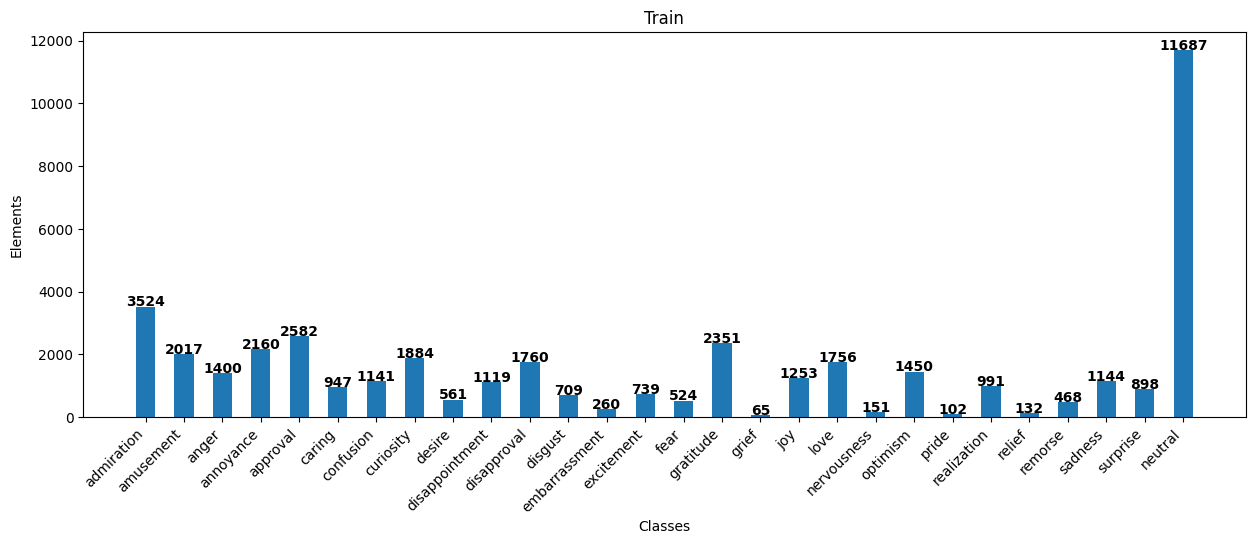

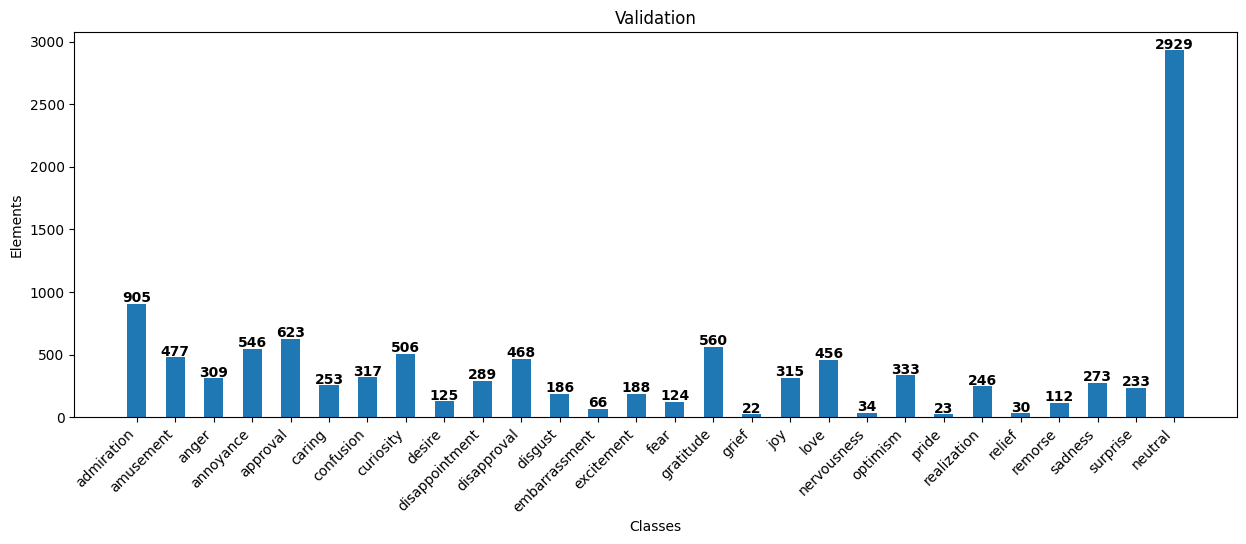

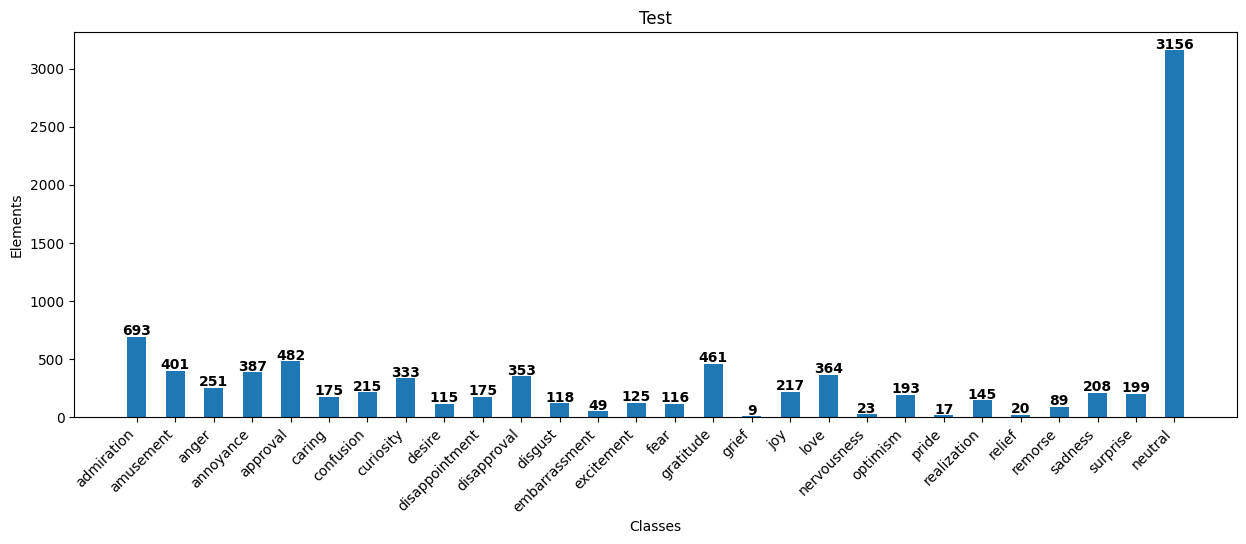

CPU times: total: 7.95 s
Wall time: 7.99 s


In [3]:
%%time
BATCH_SIZE = 64


train_df, val_df, test_df = sentiment.make_dataframes(DATASET_DIR,
                                                      fraction=0.8,
                                                      cut_neutral=False,
                                                      optimize_low=False)
dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    sentiment.plot_class_distr(df, classes, title)
train_ds = sentiment.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = sentiment.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = sentiment.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [4]:
from tensorflow.keras.layers import TextVectorization

VOCAB_SIZE = 20_000


encoder = TextVectorization(max_tokens=VOCAB_SIZE,
                            standardize='lower_and_strip_punctuation',
                            split='whitespace',
                            pad_to_max_tokens=True,
                            output_mode='int')
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'the', 'is', 'to', 'a', 'you', 'it', 'that',
       'and', 'not', 'of', 'this', 'in', 'for', 'are', 'have', 'was',
       'do'], dtype='<U270')

In [5]:
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM, Dense, Dropout)
from tensorflow.keras import Sequential

classifier = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    Bidirectional(tf.keras.layers.LSTM(64)),
    
    # Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    # Bidirectional(tf.keras.layers.LSTM(32)),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='sigmoid'),
])

In [6]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam


METRICS_THRESHOLD = 0.5
EPOCHS = 100

# Try adaptive aproach found on stackoverflow
# initial_learning_rate = 0.1
# final_learning_rate = 0.0001
# learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
# steps_per_epoch = int(train_df.shape[0]/BATCH_SIZE)

# initial_learning_rate = 0.01
# decay_steps = 10000
# decay_rate = 0.96


# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#                 initial_learning_rate=initial_learning_rate,
#                 decay_steps=steps_per_epoch,
#                 decay_rate=learning_rate_decay_factor,
#                 staircase=True)

optimizer = Adam(learning_rate=1e-4)

metrics = sentiment.create_metrics(classes, METRICS_THRESHOLD)
loss = BinaryCrossentropy()
classifier.compile(optimizer, loss=loss, metrics=metrics)

In [7]:
class_counts = sentiment.get_class_counts(train_df)
total = sum(class_counts)
class_weights = {i: total / count for i, count in enumerate(class_counts)}
class_weights

{0: 12.421963677639047,
 1: 21.703024293505205,
 2: 31.267857142857142,
 3: 20.266203703703702,
 4: 16.953911696359413,
 5: 46.22492080253432,
 6: 38.36546888694128,
 7: 23.235138004246284,
 8: 78.03030303030303,
 9: 39.11974977658624,
 10: 24.87215909090909,
 11: 61.741889985895625,
 12: 168.3653846153846,
 13: 59.23545331529093,
 14: 83.54007633587786,
 15: 18.619736282433006,
 16: 673.4615384615385,
 17: 34.93615323224262,
 18: 24.928815489749432,
 19: 289.9006622516556,
 20: 30.189655172413794,
 21: 429.1666666666667,
 22: 44.17255297679112,
 23: 331.6287878787879,
 24: 93.53632478632478,
 25: 38.26486013986014,
 26: 48.74721603563474,
 27: 3.7456147856592796}

In [8]:
from tensorflow.keras.callbacks import EarlyStopping




hist = classifier.fit(x=train_ds, validation_data=val_ds, epochs=EPOCHS,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                      # class_weight=class_weights
                     )

Epoch 1/100
565/565 [==============================] - 52s 70ms/step - loss: 0.3779 - precision@0.5/admiration: 0.0894 - recall@0.5/admiration: 0.0358 - precision@0.5/amusement: 0.0508 - recall@0.5/amusement: 0.1785 - precision@0.5/anger: 0.0380 - recall@0.5/anger: 0.0293 - precision@0.5/annoyance: 0.0597 - recall@0.5/annoyance: 0.2139 - precision@0.5/approval: 0.0684 - recall@0.5/approval: 0.2583 - precision@0.5/caring: 0.0278 - recall@0.5/caring: 0.0834 - precision@0.5/confusion: 0.0331 - recall@0.5/confusion: 0.0254 - precision@0.5/curiosity: 0.0549 - recall@0.5/curiosity: 0.0303 - precision@0.5/desire: 0.0155 - recall@0.5/desire: 0.0927 - precision@0.5/disappointment: 0.0270 - recall@0.5/disappointment: 0.0474 - precision@0.5/disapproval: 0.0522 - recall@0.5/disapproval: 0.2188 - precision@0.5/disgust: 0.0216 - recall@0.5/disgust: 0.0282 - precision@0.5/embarrassment: 0.0066 - recall@0.5/embarrassment: 0.2115 - precision@0.5/excitement: 0.0173 - recall@0.5/excitement: 0.0853 - prec

In [9]:
eval_metrics = classifier.evaluate(x=test_ds, return_dict=True)
sentiment.print_metrics(eval_metrics)

143/143 [==============================] - 3s 19ms/step - loss: 0.1124 - precision@0.5/admiration: 0.0000e+00 - recall@0.5/admiration: 0.0000e+00 - precision@0.5/amusement: 0.8163 - recall@0.5/amusement: 0.3990 - precision@0.5/anger: 0.0000e+00 - recall@0.5/anger: 0.0000e+00 - precision@0.5/annoyance: 0.0000e+00 - recall@0.5/annoyance: 0.0000e+00 - precision@0.5/approval: 0.0000e+00 - recall@0.5/approval: 0.0000e+00 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.0000e+00 - recall@0.5/confusion: 0.0000e+00 - precision@0.5/curiosity: 0.0000e+00 - recall@0.5/curiosity: 0.0000e+00 - precision@0.5/desire: 0.0000e+00 - recall@0.5/desire: 0.0000e+00 - precision@0.5/disappointment: 0.0000e+00 - recall@0.5/disappointment: 0.0000e+00 - precision@0.5/disapproval: 0.0000e+00 - recall@0.5/disapproval: 0.0000e+00 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0

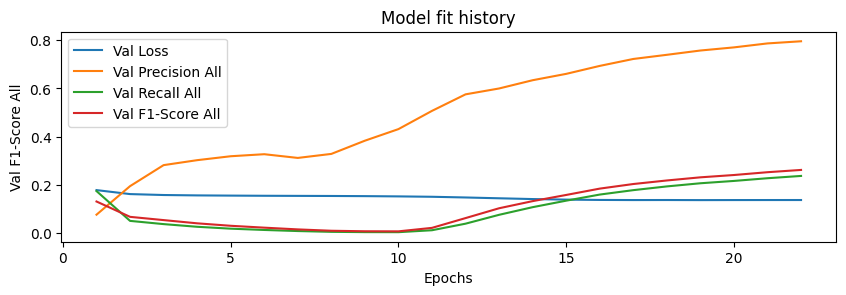

In [10]:
stats = hist.history
stats_graps = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score All': stats['f1_score@0.5/all']
}
sentiment.plot_history(stats_graps)

In [11]:
sentiment.calc_accuracy(test_ds, classifier)

0.43646166

In [12]:
sentiment.test_examples(classifier, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
I have performed well at the university: neutral ⚪
The war has started: neutral ⚪
He is desperate in this cruel world: neutral ⚪
I love the feeling when my girlfriend hugs me: gratitude 🙏
I hate monday mornings: neutral ⚪
Look forward to seeing you today: neutral ⚪
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : neutral ⚪
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): gratitude 🙏
I have the new pan for pancakes.: admiration 👏
I'm wearing a special red ribbon for luck.: optimism 🤞
OMG, yep!!! That is the final answer! Thank you so much!: gratitude 🙏
I am so glad this is over: gratitude 🙏
Sorry, I feel bad for having said that: optimism 🤞
Happy birthday, my friend! I wish you a lot of success!: optimism 🤞
What a shame! I will never talk to him: an

In [ ]:
sentiment.plot_conf_mtrx_all(classifier, test_ds, classes)

In [ ]:
sentiment.plot_conf_mtrx_per_class(classifier, test_ds, classes, rounded=False)

In [ ]:
classifier.save('./models/rnn', include_optimizer=False)

## Notes 
### Experiment 1
__Encoder:__ 20000, no ngrams, int mode   
__Dataset:__ BATCH_SIZE=64 fraction=0.8, cut_neutral=True, optimize_low=False  
__Arch:__  
__Learning:__ LR=1e-4, early stop at 5, limit for 100 epochs  
__Result:__ 1 LSTM layer with 64 units
F1Score all: `0.21518`  
Accuracy: `0.33571973`  
Approval, disappointment, disapproval, nervousness, pride, relief, neutral have zero metrics  

### Experiment 2
__Encoder:__ 20000, ngrams=2, int mode   
__Dataset:__ BATCH_SIZE=64 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__  1 LSTM layer with 64 units  
__Learning:__ LR=1e-3, early stop at 3, limit for 100 epochs  
__Result:__
F1Score all: `0.22230`  
Accuracy: `0.35515457`  
__All classes have non-zero metrics__  

### Experiment 3
__Encoder:__ 20000, ngrams=2, int mode   
__Dataset:__ BATCH_SIZE=64 fraction=0.8, cut_neutral=True, optimize_low=False  
__Arch:__  1 LSTM layer with 64 units  
__Learning:__ LR=1e-3, early stop at 3, limit for 100 epochs  
__Result:__
F1Score all: `0.3336`  
Accuracy: `0.36435643`  
nervousness, relief, neutral have zero metrics 
  
### Experiment 4
__Encoder:__ 20000, ngrams=2, int mode   
__Dataset:__ BATCH_SIZE=64 fraction=0.8, cut_neutral=True, optimize_low=False  
__Arch:__  2 LSTM layers with 64 and 32 units  
__Learning:__ Learning rate exponential starting at 0.1, early stop at 3, limit for 200 epochs  
__Result:__
F1Score all: `0.`  
Accuracy: `0.`  
__All classes have zero metrics ???__  